In [3]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
train = pd.read_csv("Titanic/train.csv")
test = pd.read_csv("Titanic/test.csv")
submit = pd.read_csv("Titanic/gender_submission.csv")

In [5]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 觀察資料是否有空值

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* 需要處理空值:Age, Cabin, Embarked

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* 需要處理空值: Age, Fare, Cabin

### 觀察數據的分佈

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* 可以看得到在train和test資料裡的Fare都有outlier   
平均32(35)元，但最大值有500+

### 資料處理
train和test都要做處理，所以先把兩筆資料合在一起處理比較省時

In [11]:
data = train.append(test)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


* 可以看到最後的index是417，也就是說append的test資料有417筆，其他的900+筆都是train的資料   

In [12]:
# 整理index順序
data.reset_index(inplace=True, drop=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Data Analysis   
先看簡單的資料分析:活與死的差別

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

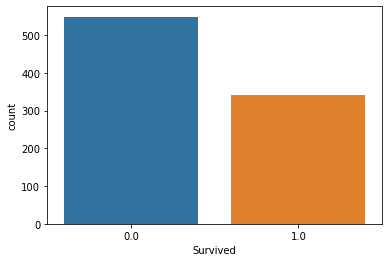

In [15]:
sns.countplot(data['Survived'])

如果在處理資料的時候，看到兩種比例很懸殊的資料，需要做更多的資料處理。   
因為通常在處理比例很懸殊的資料的權重會不一樣，在統計學會稱為false alarm和alarm false。   
這兩筆(生與死)的權重會不太一樣所以要分開計算處理。

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='count'>

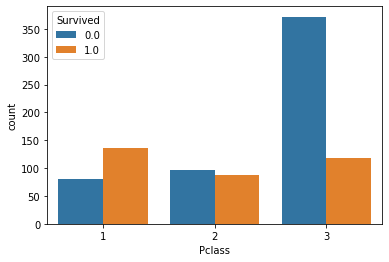

In [16]:
# Pclass艙等對survival的分析
sns.countplot(data['Pclass'], hue=data['Survived'])

* 死亡率(0)、存活率(1)
* 可以看到class1的死亡率約70，存活率約140，相當於兩倍的存活率
* class2存活和死亡約五五分
* class3的死亡率超級高   

➡艙等1和艙等2可以優先逃亡

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sex', ylabel='count'>

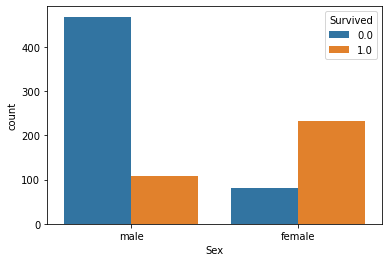

In [17]:
# Sex性別與存活率的關係
sns.countplot(data['Sex'], hue=data['Survived'])

* 可以發現男性的死亡率特別高，女性的生存率很高，由此可知在逃亡當下，是讓女生先逃跑

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

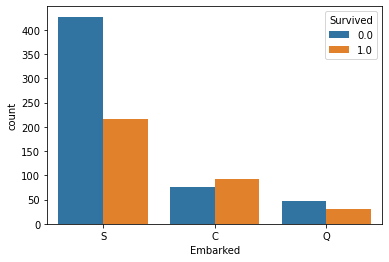

In [18]:
# Embarked登船港口與存活率的關係
sns.countplot(data['Embarked'], hue=data['Survived'])

* 從S港口登船的死亡率特別高
* C港口的死亡&生存率大概是五五波
* Q港口的死亡率也偏高一點   

➡可以推測從S港口買的票價比較便宜(class3)，或是平均收入可以比較低

以上欄位都屬於類別，Embarked有三種，male兩種，所以可以用seaborn的countplot來做呈現。  
但如果是連續資料的話，就可以用seaborn的distplot來作呈現

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


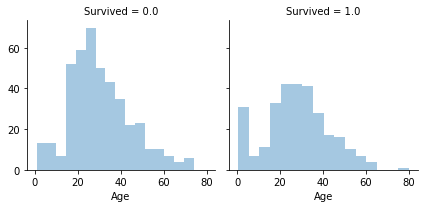

In [19]:
# 年齡跟存活率的關係
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

* 可以看到0~5歲的存活率非常非常的高，可以推論優先讓非常小的小孩先上救生船
* 但20歲以下和20~30的死亡率都偏高一點

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


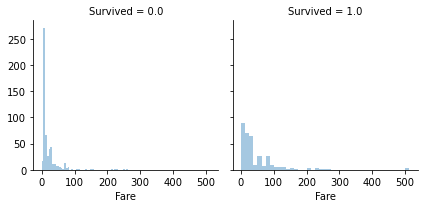

In [22]:
# 費用與存活率的關係
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Fare', kde=False)

* 可以看到票價比較便宜的死亡比例很高
* 票價比較高的存活率就也比較高

➡也符合剛剛艙等class的推論

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


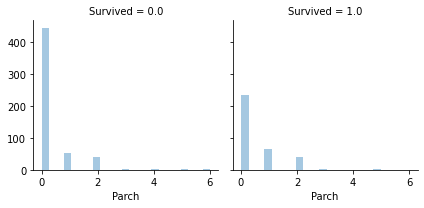

In [24]:
# Parch(父母帶小孩)與存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Parch', kde=False)

如果Parch是0的話死亡率比較高一點

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


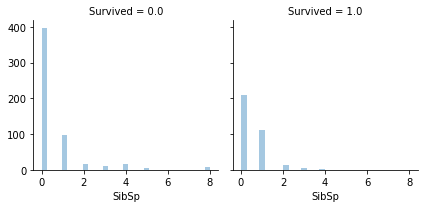

In [27]:
# SibSp(和配偶)的存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'SibSp', kde=False)

如果SibSp是0的話死亡率也比較高一點

In [28]:
# 可以把Parch和SibSp合再一起變成Family_size去做預測
data['Family_Size'] = data['Parch'] + data['SibSp']
# 如果Family_Size是0的話表示這個人單身，一個人去搭鐵達尼號，死亡率就會特別高

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


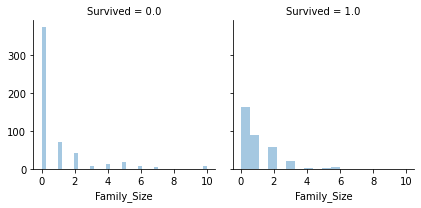

In [29]:
# Family_Size的存活率
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Family_Size', kde=False)

* 可以看到Family_Size是0的死亡率特別高

### Feature Engineering
對欄位做處理，比如姓名是文字資料，但model只能對數值資料作處理，所以要對像名字的文字資料轉成數值   
(如果變成類別的話就會是每一個類別都只有一筆資料)   
因此要觀察資料，從中整理出特徵

In [34]:
# 名字有title:Mr./Mrs.，可以從有些title推估平均年齡，可以用萃取出來的title在去預估，對年齡做補值
data['Name'].str.split(", ", expand=True).head(3)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina


In [35]:
data['Title1'] = data['Name'].str.split(", ", expand=True)[1]

In [36]:
data['Title1'].head(3)

0                               Mr. Owen Harris
1    Mrs. John Bradley (Florence Briggs Thayer)
2                                   Miss. Laina
Name: Title1, dtype: object

In [38]:
data['Title1'] = data['Title1'].str.split(".", expand=True)[0]

In [39]:
data['Title1'].head(3)

0      Mr
1     Mrs
2    Miss
Name: Title1, dtype: object

In [40]:
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [41]:
# 對這些稱謂做一些分析，比如性別
pd.crosstab(data['Title1'], data['Sex']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


可以發現大部分的稱謂都有分男女生，只有Dr是男女性都有

In [42]:
# 依據Title對存活率做分析
pd.crosstab(data['Title1'], data['Survived']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0.0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1.0,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


* 可以發現Master在性別裡都是男生，但在存活率(上表)裡3/4的存活率，跟原本在看到的男性死亡率特別高的結果不太一樣

In [43]:
# Title和Age做平均值觀察，各個title的平均年齡是多少
data.groupby(['Title1'])['Age'].mean()

Title1
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

* 可以看到Master的平均年齡只有5歲，可以推斷這是對小朋友的稱呼

In [46]:
# 接著用Title稱謂對Pclass做平均年齡的計算
data.groupby(['Title1', 'Pclass'])['Age'].mean()

Title1        Pclass
Capt          1         70.000000
Col           1         54.000000
Don           1         40.000000
Dona          1         39.000000
Dr            1         45.600000
              2         38.500000
Jonkheer      1         38.000000
Lady          1         48.000000
Major         1         48.500000
Master        1          6.984000
              2          2.757273
              3          6.090000
Miss          1         30.338983
              2         20.717083
              3         17.360874
Mlle          1         24.000000
Mme           1         24.000000
Mr            1         41.450758
              2         32.346715
              3         28.318910
Mrs           1         43.208955
              2         33.518519
              3         32.326531
Ms            2         28.000000
              3               NaN
Rev           2         41.250000
Sir           1         49.000000
the Countess  1         33.000000
Name: Age, dtype: float64

在鐵達尼號的討論區上，有很多人就是用這個方法來對年齡做預估，補年齡的缺失值(空值)

In [47]:
# 把稱謂的同義詞/相似詞換成同一個稱謂
data['Title2'] = data['Title1'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
    ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs']
    )

In [48]:
data['Title2'].unique()
# 把稱謂整理成以下四個類別

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [49]:
# 接著把這四個類別的稱謂做平均年齡
data.groupby(['Title2'])['Age'].mean()

Title2
Master     5.482642
Miss      21.824366
Mr        32.811056
Mrs       36.971264
Name: Age, dtype: float64

In [51]:
# 也對Title2對Pclass做平均年齡的計算
data.groupby(['Title2', 'Pclass'])['Age'].mean()

Title2  Pclass
Master  1          6.984000
        2          2.757273
        3          6.090000
Miss    1         30.131148
        2         20.865714
        3         17.360874
Mr      1         42.241497
        2         32.914966
        3         28.318910
Mrs     1         42.802817
        2         33.518519
        3         32.326531
Name: Age, dtype: float64

In [52]:
# Title2與性別
pd.crosstab(data['Title2'], data['Sex']).T.style.background_gradient(cmap='summer_r')

Title2,Master,Miss,Mr,Mrs
Sex,,,,
female,0,264,1,201
male,61,0,782,0


In [54]:
# Title2與存活率
pd.crosstab(data['Title2'], data['Survived']).T.style.background_gradient(cmap='summer_r')

Title2,Master,Miss,Mr,Mrs
Survived,,,,
0.0,17,55,451,26
1.0,23,130,87,102


In [55]:
# 接著對ticket欄位做處理
data['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [56]:
data['Ticket_info'] = data['Ticket'].apply(lambda x: x.replace(".", "").replace("/", "").strip().split(" ")[0] 
                                           if not x.isdigit() else 'X')

In [59]:
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Ticket_info', ylabel='count'>

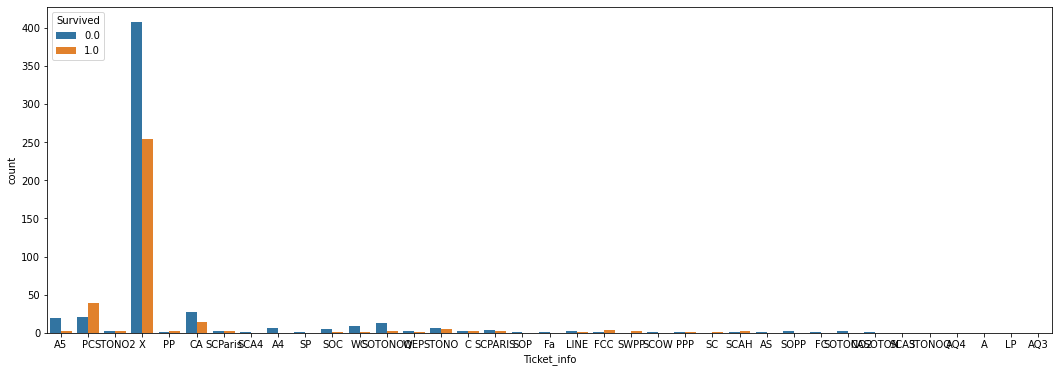

In [62]:
# 觀察這些ticket英文字母的存活率
plt.figure(figsize=(18, 6))  # 調整圖表大小
sns.countplot(data['Ticket_info'], hue=data['Survived'])

* 可以發現大部分都是X，ticket大部分都是數字
* PC的存活率偏高
* A5的死亡率特別高

### Missing Value_Embarked, Fare, Age
對缺失值做補值

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Family_Size  1309 non-null   int64  
 13  Title1       1309 non-null   object 
 14  Title2       1309 non-null   object 
 15  Ticket_info  1309 non-null   object 
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


* Survived有缺值是因為test的關係，是正常的
* 其他有缺值的有Age, Fare, Cabin, Embarked

**先處理Embarked, Fare，因為缺的資料最少，比較好處理**

In [64]:
# Embarked補最多人搭的港口

# 根據Embarked的圖，在"S"港口搭的人最多(上圖)，因此空值補S
data['Embarked'] = data['Embarked'].fillna('S')

In [65]:
# 看一次info確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Family_Size  1309 non-null   int64  
 13  Title1       1309 non-null   object 
 14  Title2       1309 non-null   object 
 15  Ticket_info  1309 non-null   object 
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


In [66]:
# Fare補平均
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Family_Size  1309 non-null   int64  
 13  Title1       1309 non-null   object 
 14  Title2       1309 non-null   object 
 15  Ticket_info  1309 non-null   object 
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


In [68]:
# 接著處理Cabin
data['Cabin']

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

和Ticket一樣，不規則的英文+數字，又有很多缺值   
可以直接丟掉(在kaggle上也是很多人會直接丟棄這個資料)

In [69]:
# 處理Cabin(房間號碼)，取出最前面的英文，先認定相同英文字母開頭的會在類似的區域
data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0] if not pd.isnull(x) else "NoCabin")
# 把x轉成str，但前提是他要不是空的(pd.isnull)，如果是空的就補"NoCabin"

In [70]:
data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cabin', ylabel='count'>

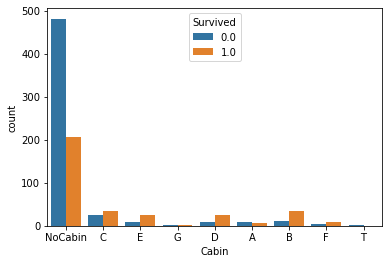

In [71]:
# Cabin房間號碼(艙)與存活率的關係
sns.countplot(data['Cabin'], hue=data['Survived'])

* 可以看到NoCabin就是沒有房間號碼的，其他有英文字母的生存率就比較高

接著針對類別資料轉成數值，因為Machin Learning的model沒辦法處理英文字母   
ML的model就是把資料的特徵變成數值，投影到空間當中，要做分類就是在空間中找到一個平面把資料做切割，而切割的線就是train出來的model

In [74]:
# 以Embarked來說，本來是C,S,Q這三個類別的類別資料，用category和.cat.codes把他轉成數值
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Embarked']

0       2
1       0
2       2
3       2
4       2
       ..
1304    2
1305    0
1306    2
1307    2
1308    0
Name: Embarked, Length: 1309, dtype: int8

這邊可以注意一下，依據之後帶的model可能轉成數值之後要再多做處理

In [75]:
# 把所有類別資料轉成數值
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes

In [78]:
# 處理Age欄位
# 先用其他欄位去預測Age的空值實際上應該是多少
# 1.資料分為兩類:有Age/無Age
dataAgeNull = data[data['Age'].isnull()]
dataAgeNotNull = data[data['Age'].notnull()]
# 2.把outlier去掉。因為outlier會影響做ML train的準確度，像Fare, Family_Size都有outlier要處理
# 只要大於4倍標準差就認定為outlier
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull['Fare'] - dataAgeNotNull['Fare'].mean()) > (4*dataAgeNotNull['Fare'].std()))|
                             (np.abs(dataAgeNotNull['Family_Size'] - dataAgeNotNull['Family_Size'].mean()) > (4*dataAgeNotNull['Family_Size'].std()))
                            ]
# 先宣告RandomForestRegressor的Model用2000顆樹做
# random_state洗牌順序，42是宅男&工程師數字
rfmodel_age = RandomForestRegressor(n_estimators=2000, random_state=42)
# 預測用的欄位
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family_Size', 'Title1', 'Title2', 'Cabin', 'Ticket_info']
# train model
rfmodel_age.fit(remove_outlier[ageColumns], remove_outlier['Age'])

# 預測Age
ageNullValues = rfmodel_age.predict(X=dataAgeNull[ageColumns])
dataAgeNull.loc[:, 'Age'] = ageNullValues # 預測完Age的值代進原本空值的資料
data = dataAgeNull.append(dataAgeNotNull) # 合併Age已經有值的資料及預測完Age的資料
data.reset_index(inplace=True, drop=True) # 整理index

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [81]:
# 依據Survived是不是空的，把資料分為train, test
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=['PassengerId'])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=['PassengerId'])

In [82]:
dataTrain.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info'],
      dtype='object')

In [89]:
# 把預測所需要的欄位挑出來
dataTrain = dataTrain[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Title2', 'Ticket_info']]
dataTest = dataTest[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Title2', 'Ticket_info']]

In [84]:
# 看一下資料
dataTrain

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family_Size,Title2,Ticket_info
263,0.0,2,1,22.000000,7.2500,7,2,1,2,2
264,1.0,0,0,38.000000,71.2833,2,0,1,3,14
265,1.0,2,0,26.000000,7.9250,7,2,0,1,31
266,1.0,0,0,35.000000,53.1000,2,2,1,3,36
267,0.0,2,1,35.000000,8.0500,7,2,0,2,36
...,...,...,...,...,...,...,...,...,...,...
973,0.0,1,1,27.000000,13.0000,7,2,0,2,36
974,1.0,0,0,19.000000,30.0000,1,2,0,1,36
176,0.0,2,0,19.099409,23.4500,7,2,3,1,34
975,1.0,0,1,26.000000,30.0000,2,0,0,2,36


### Model Training

In [ ]:
"""
前情提要: GridSearch
在不知道如何設定參數的時候，可以使用GridSearch，把所有參數的可能性和大概的範圍給出來，
讓電腦去跑，跑出最好的一組參數，再填進下方參數裡
(因為很多資訊工程背景的人，統計數學可能不那麼好~?)
這邊一跑電腦的資源就會100%的在運算這邊的參數
"""

# rf = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)
# param_grid = {"criterion": ['gini', entropy],
#               "min_samples_leaf": [1, 5, 10],
#               "min_samples_split": [2, 4, 10, 12, 16, 20]
#              }
# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# gs = gs.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])

# print(gs.best_score_)
# print(gs.best_params_)


In [86]:
# 前面已經先import過了仕くさ↓
# from sklearn.ensemble import RandomForestClassifier

# 設定參數(新手苦手...)
"""
如果直接執行的話，電腦CPU就會直接飆到100%，電腦的所有核心會拿來做運算
"""
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1000, # 樹木有幾棵，用幾顆desciontree來做預測，通常越多越好，但越多計算會越複雜
                            min_samples_split=12,
                            min_samples_leaf=1,
                            oob_score=True, # 可以使用這個參數，看train出來的結果
                            random_state=1,
                            n_jobs=-1 
                            # n_jobs:因為RandomForest支援平行運算，假設寫2，表示會用電腦2個核心去跑，-1就是電腦有幾個核心就用幾個核心
                           )
                           
rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8238


In [87]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']),
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])),
          axis=1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
1,Sex,0.267567
3,Fare,0.158593
7,Title2,0.151692
2,Age,0.135791
0,Pclass,0.089943
6,Family_Size,0.071055
4,Cabin,0.067788
8,Ticket_info,0.031645
5,Embarked,0.025927


可以看到各個欄位的重要度。   
這也是RandomForest很熱門的一個重要原因，因為在一開始沒有Domain knowledge的時候，可以直接丟到RandomForest，由統計的觀點告訴你哪些欄位是重要，先針對那些欄位去理解背後的含意。

### Submit 

In [91]:
# 把Test Data放進model裡做預測
rf_res = rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv', index=False)

In [92]:
submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
